In [203]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from IPython.display import display
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
from PIL import Image
import random

### Data Prep

In [204]:
dataset = ImageFolder('data/cats_dogs/train/')
dataset.classes

['cats', 'dogs']

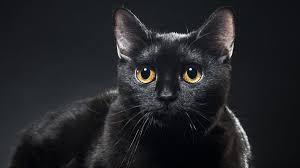

In [205]:
display(dataset[2][0])

In [206]:
len(dataset)

557

In [207]:
transform = transforms.Compose([transforms.Resize((255,255) ),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])
train_dataset = ImageFolder('data/cats_dogs_sample/train/', transform = transform)

In [208]:
train_dataset[0][0].shape

torch.Size([3, 255, 255])

In [209]:
torch.concat((train_dataset[0][0],train_dataset[1][0]), dim = 1 ).shape

torch.Size([3, 510, 255])

In [210]:
torch_concatinated = torch.concat([data[0] for data in train_dataset], dim = 1)
torch_concatinated.shape

torch.Size([3, 15300, 255])

In [211]:
mean = torch.mean(torch_concatinated, dim = (1,2))
mean

tensor([0.5762, 0.5604, 0.4927])

In [212]:
std_dev =torch.std(torch_concatinated, dim = (1,2))
std_dev

tensor([0.3023, 0.2916, 0.3174])

In [213]:
additional_transform = transforms.Compose([
    transforms.Normalize(mean, std_dev)
])
train_dataset.transform.transforms.append(additional_transform)
additional_transform

Compose(
    Normalize(mean=tensor([0.5762, 0.5604, 0.4927]), std=tensor([0.3023, 0.2916, 0.3174]))
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


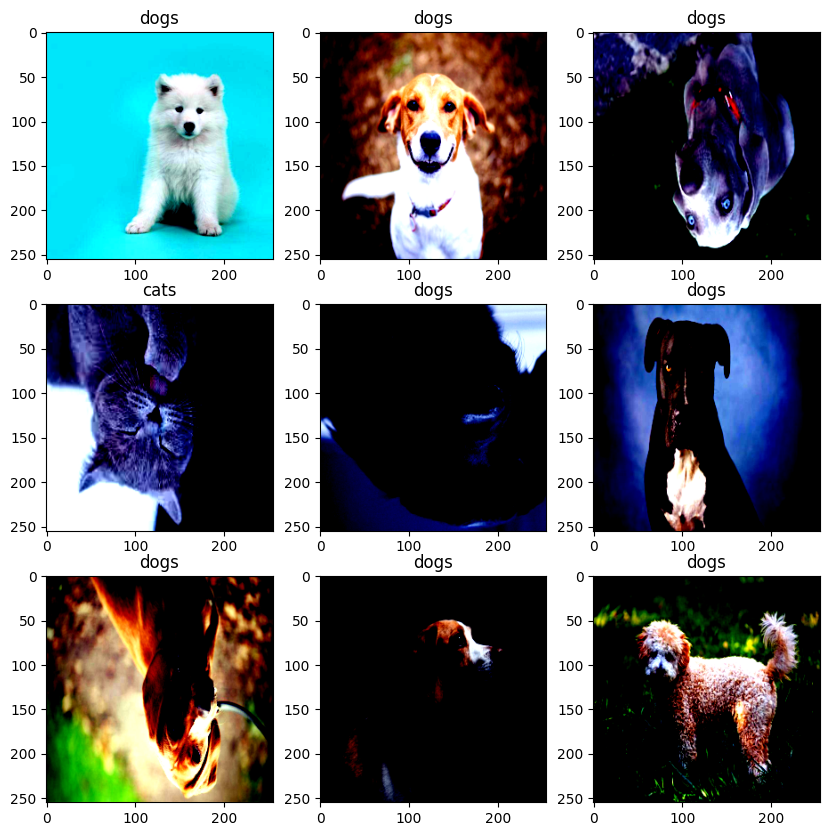

In [214]:
fig = plt.figure(figsize=(10,10))
cols = 3
rows =3
for i in range(1,cols*rows+1):
    idx = torch.randint(len(train_dataset),size=(1,)).item()
    img, label = train_dataset[idx]
    class_name = train_dataset.classes[label]
    fig.add_subplot(rows, cols, i)
    plt.title(class_name)
    plt.imshow(img.permute(1, 2, 0))
plt.show()

In [215]:
test_dataset = ImageFolder('data/cats_dogs/test/', transform = transforms.Compose([
    transforms.Resize((255, 255)),
    transforms.ToTensor()
    ,additional_transform
]))

In [216]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=2)

### Arch design phase

In [217]:
class ConvBlock(nn.Module):
    def __init__(self,c_in_channels, c_out_channels, c_kernel_size, c_stride, c_padding,
                 b_num_features,
                 m_kernal=None,m_stride=None,) -> None:
        super().__init__()
        self.c1 = nn.Conv2d(in_channels=c_in_channels, out_channels=c_out_channels, kernel_size=c_kernel_size, stride=c_stride, padding=c_padding)
        self.r1 = nn.ReLU(inplace=True)
        self.m1 = None
        if m_kernal is not None and m_stride is not None:
            self.m1 = nn.MaxPool2d(kernel_size=m_kernal, stride=m_stride)
        self.b1 = nn.BatchNorm2d(b_num_features)
    def forward(self,x):
        x = self.c1(x)
        x = self.r1(x)
        if self.m1:
            x = self.m1(x)
        x = self.b1(x)
        return x

In [218]:
class AlexNet(nn.Module):
    def __init__(self, num_classes) -> None:
        super().__init__()

        self.cb_1 = ConvBlock(3,96,11,4,2,96,3,2)
        self.cb_2 = ConvBlock(96,256,5,1,2,256,3,2)
        self.cb_3 = ConvBlock(256,384,3,1,1,384)
        self.cb_4 = ConvBlock(384,384,3,1,1,384)
        self.cb_5 = ConvBlock(384,256,3,1,1,256,3,2)
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.r1 = nn.ReLU(inplace=True)
        self.l1 = nn.Linear(256 * 6 * 6, 4096)
        self.l2 = nn.Linear(4096, 4096)
        self.out_layer = nn.Linear(4096, num_classes)
        self.d1 = nn.Dropout()
    def forward(self,x):
        x = self.cb_1(x)
        x = self.cb_2(x)
        x = self.cb_3(x)
        x = self.cb_4(x)
        x = self.cb_5(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.d1(x)
        x = self.l1(x)
        x = self.r1(x)
        x = self.d1(x)
        x = self.l2(x)
        x = self.r1(x)
        x = self.out_layer(x)
        return x


### setting up hyper parameters

In [219]:
model = AlexNet(2)

In [220]:
device = "cpu"
model.to(device=device)

AlexNet(
  (cb_1): ConvBlock(
    (c1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (r1): ReLU(inplace=True)
    (m1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (b1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cb_2): ConvBlock(
    (c1): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (r1): ReLU(inplace=True)
    (m1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (b1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cb_3): ConvBlock(
    (c1): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (r1): ReLU(inplace=True)
    (b1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cb_4): ConvBlock(
    (c1): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (r1): ReLU(inplace=True)
    (b1): BatchNorm2d(384, 

In [221]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr =  0.0001)

### training

In [222]:
train_accuracies = []
test_accuracies = []
num_epochs = 204
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track train loss and accuracy
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate train accuracy and loss
    train_accuracy = correct_train / total_train
    train_loss = train_loss / total_train
    
    train_accuracies.append(train_accuracy)
    # Evaluation (Test)
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Track test loss and accuracy
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    # Calculate test accuracy and loss
    test_accuracy = correct_test / total_test
    test_loss = test_loss / total_test
    
    test_accuracies.append(test_accuracy)

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_accuracy:.4f} - Test Loss: {test_loss:.4f} - Test Acc: {test_accuracy:.4f}")

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:16<00:00,  1.07s/it]


Epoch 1/204 - Train Loss: 0.6969 - Train Acc: 0.5333 - Test Loss: 0.6936 - Test Acc: 0.5000


100%|██████████| 15/15 [00:13<00:00,  1.07it/s]


Epoch 2/204 - Train Loss: 0.7097 - Train Acc: 0.4500 - Test Loss: 0.6926 - Test Acc: 0.5500


100%|██████████| 15/15 [00:14<00:00,  1.02it/s]


Epoch 3/204 - Train Loss: 0.7016 - Train Acc: 0.4167 - Test Loss: 0.6917 - Test Acc: 0.5429


100%|██████████| 15/15 [00:15<00:00,  1.02s/it]


Epoch 4/204 - Train Loss: 0.6754 - Train Acc: 0.5500 - Test Loss: 0.6905 - Test Acc: 0.5429


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 5/204 - Train Loss: 0.6940 - Train Acc: 0.5333 - Test Loss: 0.6905 - Test Acc: 0.5286


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Epoch 6/204 - Train Loss: 0.6740 - Train Acc: 0.6000 - Test Loss: 0.6905 - Test Acc: 0.5214


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 7/204 - Train Loss: 0.6818 - Train Acc: 0.6333 - Test Loss: 0.6900 - Test Acc: 0.5357


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 8/204 - Train Loss: 0.6779 - Train Acc: 0.5667 - Test Loss: 0.6904 - Test Acc: 0.5571


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 9/204 - Train Loss: 0.6789 - Train Acc: 0.5833 - Test Loss: 0.6907 - Test Acc: 0.5429


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Epoch 10/204 - Train Loss: 0.6878 - Train Acc: 0.4833 - Test Loss: 0.6897 - Test Acc: 0.5357


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Epoch 11/204 - Train Loss: 0.6947 - Train Acc: 0.5167 - Test Loss: 0.6894 - Test Acc: 0.5500


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Epoch 12/204 - Train Loss: 0.6805 - Train Acc: 0.5667 - Test Loss: 0.6888 - Test Acc: 0.5357


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Epoch 13/204 - Train Loss: 0.6786 - Train Acc: 0.5333 - Test Loss: 0.6884 - Test Acc: 0.5571


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Epoch 14/204 - Train Loss: 0.6673 - Train Acc: 0.6500 - Test Loss: 0.6877 - Test Acc: 0.5429


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Epoch 15/204 - Train Loss: 0.6844 - Train Acc: 0.5667 - Test Loss: 0.6877 - Test Acc: 0.5500


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Epoch 16/204 - Train Loss: 0.6800 - Train Acc: 0.5833 - Test Loss: 0.6884 - Test Acc: 0.5500


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Epoch 17/204 - Train Loss: 0.6830 - Train Acc: 0.6000 - Test Loss: 0.6880 - Test Acc: 0.5500


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Epoch 18/204 - Train Loss: 0.6958 - Train Acc: 0.4833 - Test Loss: 0.6871 - Test Acc: 0.5429


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Epoch 19/204 - Train Loss: 0.6700 - Train Acc: 0.6667 - Test Loss: 0.6876 - Test Acc: 0.5714


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 20/204 - Train Loss: 0.6645 - Train Acc: 0.6833 - Test Loss: 0.6862 - Test Acc: 0.5857


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Epoch 21/204 - Train Loss: 0.6790 - Train Acc: 0.6000 - Test Loss: 0.6861 - Test Acc: 0.5643


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Epoch 22/204 - Train Loss: 0.6830 - Train Acc: 0.5333 - Test Loss: 0.6868 - Test Acc: 0.5786


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 23/204 - Train Loss: 0.6665 - Train Acc: 0.6167 - Test Loss: 0.6870 - Test Acc: 0.5571


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Epoch 24/204 - Train Loss: 0.6656 - Train Acc: 0.7500 - Test Loss: 0.6864 - Test Acc: 0.5714


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 25/204 - Train Loss: 0.6484 - Train Acc: 0.7500 - Test Loss: 0.6862 - Test Acc: 0.5786


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 26/204 - Train Loss: 0.6682 - Train Acc: 0.6167 - Test Loss: 0.6859 - Test Acc: 0.5643


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Epoch 27/204 - Train Loss: 0.6634 - Train Acc: 0.6833 - Test Loss: 0.6859 - Test Acc: 0.5786


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 28/204 - Train Loss: 0.6699 - Train Acc: 0.6000 - Test Loss: 0.6850 - Test Acc: 0.5714


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 29/204 - Train Loss: 0.6533 - Train Acc: 0.7000 - Test Loss: 0.6852 - Test Acc: 0.5786


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 30/204 - Train Loss: 0.6700 - Train Acc: 0.6167 - Test Loss: 0.6850 - Test Acc: 0.5786


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 31/204 - Train Loss: 0.6811 - Train Acc: 0.6167 - Test Loss: 0.6846 - Test Acc: 0.5714


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 32/204 - Train Loss: 0.6739 - Train Acc: 0.5167 - Test Loss: 0.6843 - Test Acc: 0.5857


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 33/204 - Train Loss: 0.6621 - Train Acc: 0.6500 - Test Loss: 0.6841 - Test Acc: 0.5786


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 34/204 - Train Loss: 0.6508 - Train Acc: 0.7333 - Test Loss: 0.6837 - Test Acc: 0.6000


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Epoch 35/204 - Train Loss: 0.6664 - Train Acc: 0.6167 - Test Loss: 0.6836 - Test Acc: 0.5929


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 36/204 - Train Loss: 0.6507 - Train Acc: 0.6833 - Test Loss: 0.6837 - Test Acc: 0.6000


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 37/204 - Train Loss: 0.6669 - Train Acc: 0.7000 - Test Loss: 0.6835 - Test Acc: 0.5929


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 38/204 - Train Loss: 0.6566 - Train Acc: 0.7000 - Test Loss: 0.6834 - Test Acc: 0.5857


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 39/204 - Train Loss: 0.6607 - Train Acc: 0.6667 - Test Loss: 0.6835 - Test Acc: 0.5929


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 40/204 - Train Loss: 0.6319 - Train Acc: 0.7500 - Test Loss: 0.6831 - Test Acc: 0.5857


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 41/204 - Train Loss: 0.6559 - Train Acc: 0.6000 - Test Loss: 0.6832 - Test Acc: 0.6000


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 42/204 - Train Loss: 0.6388 - Train Acc: 0.7333 - Test Loss: 0.6835 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 43/204 - Train Loss: 0.6358 - Train Acc: 0.7000 - Test Loss: 0.6832 - Test Acc: 0.5857


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Epoch 44/204 - Train Loss: 0.6463 - Train Acc: 0.6500 - Test Loss: 0.6832 - Test Acc: 0.5929


100%|██████████| 15/15 [2:01:08<00:00, 484.57s/it]   


Epoch 45/204 - Train Loss: 0.6502 - Train Acc: 0.6833 - Test Loss: 0.6825 - Test Acc: 0.5929


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Epoch 46/204 - Train Loss: 0.6452 - Train Acc: 0.6833 - Test Loss: 0.6831 - Test Acc: 0.5929


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


Epoch 47/204 - Train Loss: 0.6352 - Train Acc: 0.7833 - Test Loss: 0.6833 - Test Acc: 0.5643


100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


Epoch 48/204 - Train Loss: 0.6315 - Train Acc: 0.7167 - Test Loss: 0.6832 - Test Acc: 0.5714


100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


Epoch 49/204 - Train Loss: 0.6411 - Train Acc: 0.6667 - Test Loss: 0.6831 - Test Acc: 0.5571


100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


Epoch 50/204 - Train Loss: 0.6404 - Train Acc: 0.6667 - Test Loss: 0.6816 - Test Acc: 0.5786


100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


Epoch 51/204 - Train Loss: 0.6244 - Train Acc: 0.7667 - Test Loss: 0.6817 - Test Acc: 0.6071


100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


Epoch 52/204 - Train Loss: 0.6357 - Train Acc: 0.7667 - Test Loss: 0.6819 - Test Acc: 0.5643


100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


Epoch 53/204 - Train Loss: 0.6278 - Train Acc: 0.7667 - Test Loss: 0.6833 - Test Acc: 0.5571


100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


Epoch 54/204 - Train Loss: 0.6339 - Train Acc: 0.7333 - Test Loss: 0.6819 - Test Acc: 0.5857


100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


Epoch 55/204 - Train Loss: 0.6334 - Train Acc: 0.7167 - Test Loss: 0.6820 - Test Acc: 0.5786


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Epoch 56/204 - Train Loss: 0.6113 - Train Acc: 0.8167 - Test Loss: 0.6814 - Test Acc: 0.5786


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Epoch 57/204 - Train Loss: 0.6398 - Train Acc: 0.7500 - Test Loss: 0.6815 - Test Acc: 0.5929


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Epoch 58/204 - Train Loss: 0.5881 - Train Acc: 0.8167 - Test Loss: 0.6811 - Test Acc: 0.5929


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 59/204 - Train Loss: 0.6300 - Train Acc: 0.7500 - Test Loss: 0.6815 - Test Acc: 0.5714


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Epoch 60/204 - Train Loss: 0.6265 - Train Acc: 0.7500 - Test Loss: 0.6817 - Test Acc: 0.5929


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Epoch 61/204 - Train Loss: 0.6289 - Train Acc: 0.7667 - Test Loss: 0.6808 - Test Acc: 0.5929


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Epoch 62/204 - Train Loss: 0.6120 - Train Acc: 0.8000 - Test Loss: 0.6809 - Test Acc: 0.5857


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 63/204 - Train Loss: 0.6050 - Train Acc: 0.8000 - Test Loss: 0.6808 - Test Acc: 0.5857


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 64/204 - Train Loss: 0.6125 - Train Acc: 0.7833 - Test Loss: 0.6806 - Test Acc: 0.5786


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 65/204 - Train Loss: 0.6039 - Train Acc: 0.9000 - Test Loss: 0.6798 - Test Acc: 0.5857


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Epoch 66/204 - Train Loss: 0.6133 - Train Acc: 0.8000 - Test Loss: 0.6795 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Epoch 67/204 - Train Loss: 0.6168 - Train Acc: 0.8000 - Test Loss: 0.6805 - Test Acc: 0.5857


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Epoch 68/204 - Train Loss: 0.6228 - Train Acc: 0.7833 - Test Loss: 0.6794 - Test Acc: 0.5786


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 69/204 - Train Loss: 0.6284 - Train Acc: 0.7167 - Test Loss: 0.6792 - Test Acc: 0.5929


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 70/204 - Train Loss: 0.6070 - Train Acc: 0.8333 - Test Loss: 0.6794 - Test Acc: 0.5857


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Epoch 71/204 - Train Loss: 0.6036 - Train Acc: 0.7833 - Test Loss: 0.6803 - Test Acc: 0.5857


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 72/204 - Train Loss: 0.5986 - Train Acc: 0.8167 - Test Loss: 0.6794 - Test Acc: 0.5857


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Epoch 73/204 - Train Loss: 0.5816 - Train Acc: 0.8667 - Test Loss: 0.6795 - Test Acc: 0.5929


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 74/204 - Train Loss: 0.6303 - Train Acc: 0.7667 - Test Loss: 0.6786 - Test Acc: 0.5929


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 75/204 - Train Loss: 0.6036 - Train Acc: 0.7833 - Test Loss: 0.6789 - Test Acc: 0.5929


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 76/204 - Train Loss: 0.6032 - Train Acc: 0.7833 - Test Loss: 0.6789 - Test Acc: 0.5857


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Epoch 77/204 - Train Loss: 0.5960 - Train Acc: 0.8167 - Test Loss: 0.6796 - Test Acc: 0.5929


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 78/204 - Train Loss: 0.6144 - Train Acc: 0.7500 - Test Loss: 0.6793 - Test Acc: 0.5857


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 79/204 - Train Loss: 0.5829 - Train Acc: 0.8000 - Test Loss: 0.6786 - Test Acc: 0.5929


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Epoch 80/204 - Train Loss: 0.5928 - Train Acc: 0.8000 - Test Loss: 0.6783 - Test Acc: 0.5857


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 81/204 - Train Loss: 0.5821 - Train Acc: 0.8667 - Test Loss: 0.6780 - Test Acc: 0.5857


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 82/204 - Train Loss: 0.5890 - Train Acc: 0.8000 - Test Loss: 0.6786 - Test Acc: 0.5929


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 83/204 - Train Loss: 0.5915 - Train Acc: 0.8167 - Test Loss: 0.6783 - Test Acc: 0.5786


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Epoch 84/204 - Train Loss: 0.6160 - Train Acc: 0.6833 - Test Loss: 0.6778 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Epoch 85/204 - Train Loss: 0.6022 - Train Acc: 0.7833 - Test Loss: 0.6775 - Test Acc: 0.6000


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 86/204 - Train Loss: 0.5684 - Train Acc: 0.9167 - Test Loss: 0.6779 - Test Acc: 0.5929


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 87/204 - Train Loss: 0.5900 - Train Acc: 0.8500 - Test Loss: 0.6765 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 88/204 - Train Loss: 0.5813 - Train Acc: 0.8333 - Test Loss: 0.6770 - Test Acc: 0.6000


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 89/204 - Train Loss: 0.5765 - Train Acc: 0.7833 - Test Loss: 0.6767 - Test Acc: 0.5929


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 90/204 - Train Loss: 0.5747 - Train Acc: 0.8167 - Test Loss: 0.6780 - Test Acc: 0.5857


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 91/204 - Train Loss: 0.5937 - Train Acc: 0.8000 - Test Loss: 0.6769 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 92/204 - Train Loss: 0.5848 - Train Acc: 0.8333 - Test Loss: 0.6766 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 93/204 - Train Loss: 0.6025 - Train Acc: 0.7667 - Test Loss: 0.6778 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Epoch 94/204 - Train Loss: 0.5903 - Train Acc: 0.8500 - Test Loss: 0.6773 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 95/204 - Train Loss: 0.5737 - Train Acc: 0.8333 - Test Loss: 0.6762 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 96/204 - Train Loss: 0.5745 - Train Acc: 0.8167 - Test Loss: 0.6779 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 97/204 - Train Loss: 0.5690 - Train Acc: 0.8000 - Test Loss: 0.6773 - Test Acc: 0.5857


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 98/204 - Train Loss: 0.5810 - Train Acc: 0.7833 - Test Loss: 0.6774 - Test Acc: 0.6000


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Epoch 99/204 - Train Loss: 0.5729 - Train Acc: 0.8833 - Test Loss: 0.6771 - Test Acc: 0.6000


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Epoch 100/204 - Train Loss: 0.5664 - Train Acc: 0.8500 - Test Loss: 0.6764 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 101/204 - Train Loss: 0.5905 - Train Acc: 0.7833 - Test Loss: 0.6776 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 102/204 - Train Loss: 0.5585 - Train Acc: 0.8667 - Test Loss: 0.6776 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Epoch 103/204 - Train Loss: 0.5667 - Train Acc: 0.8000 - Test Loss: 0.6767 - Test Acc: 0.6000


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 104/204 - Train Loss: 0.5591 - Train Acc: 0.8667 - Test Loss: 0.6774 - Test Acc: 0.6000


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Epoch 105/204 - Train Loss: 0.5655 - Train Acc: 0.8000 - Test Loss: 0.6769 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Epoch 106/204 - Train Loss: 0.5454 - Train Acc: 0.8333 - Test Loss: 0.6782 - Test Acc: 0.5929


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 107/204 - Train Loss: 0.5591 - Train Acc: 0.8500 - Test Loss: 0.6768 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 108/204 - Train Loss: 0.5671 - Train Acc: 0.8333 - Test Loss: 0.6781 - Test Acc: 0.6000


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 109/204 - Train Loss: 0.5623 - Train Acc: 0.8667 - Test Loss: 0.6776 - Test Acc: 0.5857


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 110/204 - Train Loss: 0.5474 - Train Acc: 0.8333 - Test Loss: 0.6769 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 111/204 - Train Loss: 0.5443 - Train Acc: 0.9333 - Test Loss: 0.6772 - Test Acc: 0.6000


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 112/204 - Train Loss: 0.5569 - Train Acc: 0.8667 - Test Loss: 0.6763 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 113/204 - Train Loss: 0.5282 - Train Acc: 0.8833 - Test Loss: 0.6768 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 114/204 - Train Loss: 0.5667 - Train Acc: 0.8167 - Test Loss: 0.6756 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 115/204 - Train Loss: 0.5433 - Train Acc: 0.8833 - Test Loss: 0.6765 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 116/204 - Train Loss: 0.5520 - Train Acc: 0.8500 - Test Loss: 0.6761 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 117/204 - Train Loss: 0.5301 - Train Acc: 0.8667 - Test Loss: 0.6773 - Test Acc: 0.6000


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 118/204 - Train Loss: 0.5505 - Train Acc: 0.8500 - Test Loss: 0.6767 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Epoch 119/204 - Train Loss: 0.5374 - Train Acc: 0.8500 - Test Loss: 0.6764 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 120/204 - Train Loss: 0.5177 - Train Acc: 0.9333 - Test Loss: 0.6768 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 121/204 - Train Loss: 0.5407 - Train Acc: 0.8500 - Test Loss: 0.6759 - Test Acc: 0.6000


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Epoch 122/204 - Train Loss: 0.5509 - Train Acc: 0.8500 - Test Loss: 0.6764 - Test Acc: 0.6000


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Epoch 123/204 - Train Loss: 0.5554 - Train Acc: 0.8333 - Test Loss: 0.6765 - Test Acc: 0.6000


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Epoch 124/204 - Train Loss: 0.5095 - Train Acc: 0.8833 - Test Loss: 0.6775 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 125/204 - Train Loss: 0.5239 - Train Acc: 0.8167 - Test Loss: 0.6767 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 126/204 - Train Loss: 0.5233 - Train Acc: 0.9000 - Test Loss: 0.6773 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Epoch 127/204 - Train Loss: 0.5183 - Train Acc: 0.8500 - Test Loss: 0.6772 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 128/204 - Train Loss: 0.5207 - Train Acc: 0.8500 - Test Loss: 0.6773 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 129/204 - Train Loss: 0.5115 - Train Acc: 0.8667 - Test Loss: 0.6781 - Test Acc: 0.6000


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Epoch 130/204 - Train Loss: 0.5191 - Train Acc: 0.8333 - Test Loss: 0.6769 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 131/204 - Train Loss: 0.5214 - Train Acc: 0.8167 - Test Loss: 0.6779 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 132/204 - Train Loss: 0.5241 - Train Acc: 0.8333 - Test Loss: 0.6768 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 133/204 - Train Loss: 0.5371 - Train Acc: 0.8167 - Test Loss: 0.6784 - Test Acc: 0.5929


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 134/204 - Train Loss: 0.5371 - Train Acc: 0.8500 - Test Loss: 0.6784 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 135/204 - Train Loss: 0.5267 - Train Acc: 0.8333 - Test Loss: 0.6788 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 136/204 - Train Loss: 0.5157 - Train Acc: 0.8667 - Test Loss: 0.6778 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 137/204 - Train Loss: 0.5351 - Train Acc: 0.8167 - Test Loss: 0.6784 - Test Acc: 0.6000


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 138/204 - Train Loss: 0.4891 - Train Acc: 0.8667 - Test Loss: 0.6782 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 139/204 - Train Loss: 0.5306 - Train Acc: 0.8500 - Test Loss: 0.6772 - Test Acc: 0.6143


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


Epoch 140/204 - Train Loss: 0.5086 - Train Acc: 0.8333 - Test Loss: 0.6791 - Test Acc: 0.6214


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


Epoch 141/204 - Train Loss: 0.4870 - Train Acc: 0.8667 - Test Loss: 0.6793 - Test Acc: 0.6143


100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


Epoch 142/204 - Train Loss: 0.5018 - Train Acc: 0.8667 - Test Loss: 0.6778 - Test Acc: 0.6143


100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


Epoch 143/204 - Train Loss: 0.4958 - Train Acc: 0.9000 - Test Loss: 0.6789 - Test Acc: 0.6071


100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


Epoch 144/204 - Train Loss: 0.5040 - Train Acc: 0.8333 - Test Loss: 0.6797 - Test Acc: 0.6143


100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


Epoch 145/204 - Train Loss: 0.5196 - Train Acc: 0.8667 - Test Loss: 0.6797 - Test Acc: 0.6143


100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


Epoch 146/204 - Train Loss: 0.5112 - Train Acc: 0.8833 - Test Loss: 0.6799 - Test Acc: 0.6071


100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


Epoch 147/204 - Train Loss: 0.5010 - Train Acc: 0.8500 - Test Loss: 0.6799 - Test Acc: 0.6071


100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


Epoch 148/204 - Train Loss: 0.4943 - Train Acc: 0.9000 - Test Loss: 0.6791 - Test Acc: 0.6071


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


Epoch 149/204 - Train Loss: 0.5006 - Train Acc: 0.8500 - Test Loss: 0.6795 - Test Acc: 0.6000


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Epoch 150/204 - Train Loss: 0.4838 - Train Acc: 0.8667 - Test Loss: 0.6798 - Test Acc: 0.6000


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Epoch 151/204 - Train Loss: 0.4862 - Train Acc: 0.9000 - Test Loss: 0.6800 - Test Acc: 0.6000


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 152/204 - Train Loss: 0.5037 - Train Acc: 0.8333 - Test Loss: 0.6797 - Test Acc: 0.6000


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 153/204 - Train Loss: 0.4728 - Train Acc: 0.9000 - Test Loss: 0.6793 - Test Acc: 0.5929


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 154/204 - Train Loss: 0.4746 - Train Acc: 0.9167 - Test Loss: 0.6800 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 155/204 - Train Loss: 0.5065 - Train Acc: 0.8000 - Test Loss: 0.6807 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 156/204 - Train Loss: 0.4981 - Train Acc: 0.8833 - Test Loss: 0.6789 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 157/204 - Train Loss: 0.4660 - Train Acc: 0.9333 - Test Loss: 0.6796 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 158/204 - Train Loss: 0.4883 - Train Acc: 0.8333 - Test Loss: 0.6801 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 159/204 - Train Loss: 0.4582 - Train Acc: 0.9500 - Test Loss: 0.6800 - Test Acc: 0.6214


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 160/204 - Train Loss: 0.4742 - Train Acc: 0.8333 - Test Loss: 0.6802 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 161/204 - Train Loss: 0.4719 - Train Acc: 0.9167 - Test Loss: 0.6799 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 162/204 - Train Loss: 0.4668 - Train Acc: 0.8333 - Test Loss: 0.6792 - Test Acc: 0.6214


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 163/204 - Train Loss: 0.4532 - Train Acc: 0.9000 - Test Loss: 0.6803 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Epoch 164/204 - Train Loss: 0.4714 - Train Acc: 0.9333 - Test Loss: 0.6808 - Test Acc: 0.6214


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 165/204 - Train Loss: 0.4885 - Train Acc: 0.8500 - Test Loss: 0.6830 - Test Acc: 0.5857


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 166/204 - Train Loss: 0.4545 - Train Acc: 0.9167 - Test Loss: 0.6808 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 167/204 - Train Loss: 0.4722 - Train Acc: 0.9000 - Test Loss: 0.6800 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 168/204 - Train Loss: 0.4673 - Train Acc: 0.9333 - Test Loss: 0.6809 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 169/204 - Train Loss: 0.4584 - Train Acc: 0.8833 - Test Loss: 0.6841 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 170/204 - Train Loss: 0.4423 - Train Acc: 0.9000 - Test Loss: 0.6810 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Epoch 171/204 - Train Loss: 0.4590 - Train Acc: 0.8833 - Test Loss: 0.6818 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 172/204 - Train Loss: 0.4583 - Train Acc: 0.9167 - Test Loss: 0.6827 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 173/204 - Train Loss: 0.4637 - Train Acc: 0.8333 - Test Loss: 0.6807 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 174/204 - Train Loss: 0.4342 - Train Acc: 0.9000 - Test Loss: 0.6827 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 175/204 - Train Loss: 0.4388 - Train Acc: 0.9333 - Test Loss: 0.6821 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 176/204 - Train Loss: 0.4616 - Train Acc: 0.8833 - Test Loss: 0.6803 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 177/204 - Train Loss: 0.4727 - Train Acc: 0.7833 - Test Loss: 0.6809 - Test Acc: 0.6000


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 178/204 - Train Loss: 0.4647 - Train Acc: 0.8833 - Test Loss: 0.6813 - Test Acc: 0.6000


100%|██████████| 15/15 [00:16<00:00,  1.07s/it]


Epoch 179/204 - Train Loss: 0.4460 - Train Acc: 0.9500 - Test Loss: 0.6820 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Epoch 180/204 - Train Loss: 0.4299 - Train Acc: 0.9167 - Test Loss: 0.6810 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 181/204 - Train Loss: 0.4130 - Train Acc: 0.9333 - Test Loss: 0.6821 - Test Acc: 0.6000


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Epoch 182/204 - Train Loss: 0.4730 - Train Acc: 0.8667 - Test Loss: 0.6834 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 183/204 - Train Loss: 0.4468 - Train Acc: 0.9167 - Test Loss: 0.6825 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Epoch 184/204 - Train Loss: 0.4254 - Train Acc: 0.9000 - Test Loss: 0.6821 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 185/204 - Train Loss: 0.4420 - Train Acc: 0.8833 - Test Loss: 0.6823 - Test Acc: 0.6214


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 186/204 - Train Loss: 0.4353 - Train Acc: 0.9000 - Test Loss: 0.6845 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Epoch 187/204 - Train Loss: 0.4438 - Train Acc: 0.8833 - Test Loss: 0.6832 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 188/204 - Train Loss: 0.4282 - Train Acc: 0.9000 - Test Loss: 0.6845 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Epoch 189/204 - Train Loss: 0.4433 - Train Acc: 0.9000 - Test Loss: 0.6844 - Test Acc: 0.6000


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Epoch 190/204 - Train Loss: 0.4207 - Train Acc: 0.8833 - Test Loss: 0.6841 - Test Acc: 0.6143


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Epoch 191/204 - Train Loss: 0.4248 - Train Acc: 0.9333 - Test Loss: 0.6862 - Test Acc: 0.6143


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


Epoch 192/204 - Train Loss: 0.4238 - Train Acc: 0.9167 - Test Loss: 0.6854 - Test Acc: 0.6071


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Epoch 193/204 - Train Loss: 0.4158 - Train Acc: 0.9333 - Test Loss: 0.6839 - Test Acc: 0.6214


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Epoch 194/204 - Train Loss: 0.4134 - Train Acc: 0.9333 - Test Loss: 0.6854 - Test Acc: 0.6214


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Epoch 195/204 - Train Loss: 0.4098 - Train Acc: 0.9167 - Test Loss: 0.6849 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Epoch 196/204 - Train Loss: 0.4271 - Train Acc: 0.8667 - Test Loss: 0.6838 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 197/204 - Train Loss: 0.4177 - Train Acc: 0.9167 - Test Loss: 0.6833 - Test Acc: 0.6214


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 198/204 - Train Loss: 0.4047 - Train Acc: 0.8833 - Test Loss: 0.6837 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 199/204 - Train Loss: 0.4238 - Train Acc: 0.8667 - Test Loss: 0.6856 - Test Acc: 0.6071


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 200/204 - Train Loss: 0.4261 - Train Acc: 0.9000 - Test Loss: 0.6823 - Test Acc: 0.6214


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 201/204 - Train Loss: 0.4056 - Train Acc: 0.9333 - Test Loss: 0.6852 - Test Acc: 0.6214


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 202/204 - Train Loss: 0.4151 - Train Acc: 0.8833 - Test Loss: 0.6838 - Test Acc: 0.6214


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Epoch 203/204 - Train Loss: 0.3973 - Train Acc: 0.8667 - Test Loss: 0.6838 - Test Acc: 0.6143


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Epoch 204/204 - Train Loss: 0.3999 - Train Acc: 0.9167 - Test Loss: 0.6840 - Test Acc: 0.6214


In [223]:
torch.save(model.state_dict(),"model/cat_dog_204epoch.pth")

### Prediction

In [194]:
loaded_model = AlexNet(2)
loaded_model.load_state_dict(torch.load("model/base_model_v1.pth"))

<All keys matched successfully>

In [195]:
additional_transform

Compose(
    Normalize(mean=tensor([0.5762, 0.5604, 0.4927]), std=tensor([0.3023, 0.2916, 0.3174]))
)

In [196]:
class ClassPredictor:
    def __init__(self,model,class_map) -> None:
        self.model = model
        self.class_map = class_map
    def preprocess(self,img_path):
        preprocess =transforms.Compose([
            transforms.Resize((255, 255)),
            transforms.ToTensor()
            ,transforms.Normalize(mean=[0.5762, 0.5604, 0.4927], std=[0.3023, 0.2916, 0.3174])
        ])
        image = Image.open(img_path).convert("RGB")
        image = preprocess(image)
        image = image.unsqueeze(0)
        return image
    def model_pred(self,img_tensor):
        self.model.eval()
        with torch.no_grad():
            output = self.model(img_tensor)
        _, pred_class = output.max(1)
        return self.class_map[pred_class.item()]
    def predict(self,img_path):
        img_tensor = self.preprocess(img_path=img_path)
        return self.model_pred(img_tensor=img_tensor)

In [197]:
class_map = {
    0:"cat",
    1:"dog"
}
pred_obj = ClassPredictor(model=model,class_map=class_map)

In [202]:
img_path = 'data/cats_dogs/test/cats/cat_114.jpg'
pred_obj.predict(img_path)

'cat'

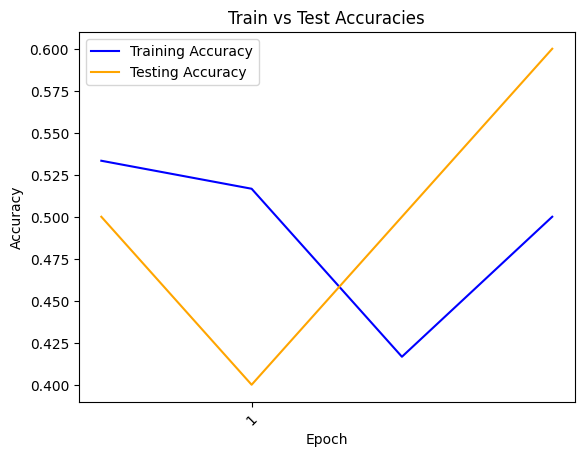

In [157]:
sns.lineplot(x = range(4), y = train_accuracies, color = "blue", label = "Training Accuracy")
sns.lineplot(x = range(4), y = test_accuracies, color = "orange", label = "Testing Accuracy")
plt.title("Train vs Test Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(1,4,10), rotation = 45)
plt.yticks(label = range(1,4,15))
plt.legend()
plt.show()